## Vokabularienvergleich

In [123]:
import csv
import json
import nltk
from tabulate import tabulate
from collections import Counter
import string
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re

### Überblick über Daten

Englisch:
- ACDH-CH-Website
- DARIAH Campus
- TaDiRAH
- TaDiRAH-Products
- Arche (teilweise)
- dha (teilweise)
- HowTo (teilweise)
- GAMS (teilweise)
- Zotero (teilweise)

Deutsch:
- Arche (teilweise)
- dha (teilweise)
- HowTo (teilweise)
- GAMS (teilweise)
- Zotero (teilweise)





Anmerkung: Nur eindeutig deutsche Termini (z.B: Datenbank, Tagebuch) inkludiert; englische Begriffe oder Abkürzungen (z.B. Linked Open Data, TEI, RDF, ...), die im Deutschen geläufig sind, zählen zum Englischen und werden dort verglichen.

### Datenimport

In [124]:
#ACDH-CH HowTo (ht) - getrennt nach Sprache(n)

with open("HowTo_ergänzt.json", encoding = "utf-8") as datei:
    ht_orig = json.load(datei)

ht_de = {key.lower():value for (key,value) in ht_orig.items() if key == "Datenmanagement"}
ht_en = {key.lower():value for (key,value) in ht_orig.items() if key != "Datenmanagement"}

In [125]:
#Import der ARCHE-Tags (hasSubject + hasAppliedMethod + hasCategory)
#zusätzliche Informationen: Property, Language, Variants
#Behandlung der drei Properties als drei verschiedene Vokabularien

arche_hasSubject_orig = {}
arche_hasAppliedMethod_orig = {}
arche_hasCategory_orig = {}

with open("ARCHE_Languagetags_2022-12-02.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.strip().split(";")
        if element[0] == "id":
            continue
        else:
            tag = element[1]
            lang = element[4]
            variants = element[6]
            if variants != "":
                total = variants.split(", ")
                total.append(tag)
                for variant in total:
                    if "hasSubject" in element[3]:
                        arche_hasSubject_orig[variant] = lang
                    elif "hasAppliedMethod" in element[3]:
                        arche_hasAppliedMethod_orig[variant] = lang
                    elif "hasCategory" in element[3]:
                        arche_hasCategory_orig[variant] = lang
            else:
                if "hasSubject" in element[3]:
                    arche_hasSubject_orig[tag] = lang
                elif "hasAppliedMethod" in element[3]:
                    arche_hasAppliedMethod_orig[tag] = lang
                elif "hasCategory" in element[3]:
                    arche_hasCategory_orig[tag] = lang

#Zwei Varianten: Deutsch vs. Englisch

arche_hasSubject_de = {key.lower():value for (key,value) in arche_hasSubject_orig.items() if value == "de" or value == "und"}
arche_hasSubject_en = {key.lower():value for (key,value) in arche_hasSubject_orig.items() if value == "en" or value == "und"}
arche_hasAppliedMethod_de = {key.lower():value for (key,value) in arche_hasAppliedMethod_orig.items() if value == "de" or value == "und"}
arche_hasAppliedMethod_en = {key.lower():value for (key,value) in arche_hasAppliedMethod_orig.items() if value == "en" or value == "und"}
arche_hasCategory_de = {key.lower():value for (key,value) in arche_hasCategory_orig.items() if value == "de" or value == "und"}
arche_hasCategory_en = {key.lower():value for (key,value) in arche_hasCategory_orig.items() if value == "en" or value == "und"}

In [126]:
#Import der dha-Tags - getrennt nach Sprachen
#Notiz: eine Dopplung ("political science" zweimal, mit je Count = 1) direkt im .csv korrigiert

dha_orig = {}

with open("dha_cleaned+lang_02.12.2022.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.strip().split(";")
        tag = element[0]
        cleaned = element[1]
        lang = element[3]
        if cleaned != "":
            tags = cleaned.split(", ")
            for element in tags:
                dha_orig[element] = lang
        else:
            dha_orig[tag] = lang

#Entfernen der ersten Zeile - optional, da Weiterverarbeitung im nächsten Schritt
del dha_orig["Cleaned Version"]

dha_de = {key.lower():value for (key,value) in dha_orig.items() if value == "de" or value == "und"}
dha_en = {key.lower():value for (key,value) in dha_orig.items() if value == "en" or value == "und"}

In [127]:
#Import der Tags der KONDE-Zotero-Gruppe - nach Sprachen getrennt
#Zusatzinformation: Sprache (manuell jweils als en, de, en/de oder other (d.h. andere Sprache) klassifiziert)

zotero_orig = {}

#Extraschritt bei Zotero: Cleaning von metatextuellen Markierungen folgender Art sowie Trennung von mehreren Tags in einem Tag
metamarkierungen = ["act_", "activity: ", "meta_", "university: ", "dm_", "type: ", "t_", "obj_", "object: ", "goal_", "field: ", "supervisor: "]
#seperatoren = [" / ", ", ", " - ", " & ", "&"]

with open("Zotero.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.strip("\ufeff").strip().split(";")
        tag = element[0]
        cleaned = element[1]
        lang = element[2]
        if cleaned != "":
            tags = cleaned.split(",")
            for element in tags:
                zotero_orig[element] = lang
        else:
            for markierung in metamarkierungen:
                tag = tag.replace(markierung, "")
            if re.findall("[a-z][A-Z]", tag) and tag != "Thesis (PhD level)":
                for match in re.finditer(("[a-z][A-Z]"), tag):
                    start = match.start() #gibt Index des ersten Zeichens von Match aus
                    end = match.end()
                    tag = tag[:start+1] + " " + tag[end-1:]
            zotero_orig[tag] = lang

#Entfernen der ersten Zeile eines Eintrags mit Beistrichen im Tag - optional, da Weiterverarbeitung im nächsten Schritt
del zotero_orig["Cleaned Version"]

zotero_de = {key.lower():value for (key,value) in zotero_orig.items() if value == "de" or value == "und"}
zotero_en = {key.lower():value for (key,value) in zotero_orig.items() if value == "en" or value == "und"}

In [128]:
#Import der Tags von GAMS - nach Sprachen getrennt
#zusätzliche Informationen: Sprache (de/en), Kategorie (Disziplin/Thema/Quellenmaterial/Methode/Periode), ID (manuell hinzugefügt, um Übersetzungen wiederzufinden)

gams_orig = {}

with open("GAMS.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.strip().split(";")
        tag = element[0]
        if tag == "\ufeffTag":
            continue
        lang = element[1] #Sprache
        #cat = element[2] #Kategorie
        #id = element[3] #ID
        gams_orig[tag] = lang

gams_de = {key.lower():value for (key,value) in gams_orig.items() if value == "de"}
gams_en = {key.lower():value for (key,value) in gams_orig.items() if value == "en"}

#Eintrag "Autor/Schriftsteller" bzw. "author/novelist" manuell getrennt (und zu "autor" im Deutschen)
del gams_en["author/novelist"]
del gams_de["author/schriftsteller"]
gams_en["author"] = "en"
gams_en["novelist"] = "en"
gams_de["autor"] = "de"
gams_de["schriftsteller"] = "de"

### Import der einsprachigen Vokabularien

In [129]:
#Import von DARIAH-Campus (dc)
#zusätzliche Informationen: Count

with open("DARIAH-Campus_Topics.json", encoding = "utf-8") as datei:
    dc_orig = json.load(datei)

In [130]:
#Import der Tags der ACDH-CH-Website (acdh)
#zusätzliche Informationen: Count für Tools, Count für Projekte, Count insgesamt

acdh_orig = {}

with open("Tags_ACDH-CH-Website.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.strip().split(";")
        tag = element[0]
        count_tools = element[1]
        count_projects = element[2]
        count = element[3]
        if tag == "\ufeffTag" or tag == "Summe":
            continue
        else:
            acdh_orig[tag] = {"count_tools": count_tools, "count_projects": count_projects, "count": count}

In [131]:
#Import der TaDiRAH-Tags
#zusätzliche Information: Synonym, falls es sich bei Tag um alternative Bezeichnung handelt (z.B. OCR --> Optical Character Recognition)

tadirah_orig = {}

with open("TaDiRAH.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.strip().split(";")
        tag = element[0]
        synonym = element[1] 
        if tag == "\ufeffTag":
            continue
        else:
            tadirah_orig[tag] = {"synonym": synonym}

In [132]:
#Import der TaDiRAH-Product-Tags
#zusätzliche Information: Level in Tadirah, Synonym, gemappter Terminus in dha, (gemappter Terminus in Wikidata)

tadirah_prod_orig = {}

with open("TaDiRAH_products.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.strip().split(";")
        tag = element[1].strip("()?") #aktuell noch Klammern und Fragezeichen im GoogleSheet - hier herausgelöscht
        level = element[2] #Level in Tadirah (wenn ein Tag auf mehreren Leveln vorkommt, werden diese in einer Liste gesammelt)
        synonym = element[3] #etwaige eingetragene Synonyme - z.B. Addition zu Adding
        dha_match = element[4] #gemappter Terminus im dha-Tagset
        if tag == "Tag" or tag == "":
            continue
        else:
            if tag not in tadirah_prod_orig.keys():
                tadirah_prod_orig[tag] = {"level": [level], "synonym": synonym, "dha_match": dha_match}
            else:
                tadirah_prod_orig[tag]["level"].append(level)

In [133]:
#Normalisierung: alle Tags in Kleinschreibung (Umwandlung: acdh_orig > acdh)

acdh = {key.lower():value for (key,value) in acdh_orig.items()}
dc = {key.lower():value for (key,value) in dc_orig.items()}
tadirah = {key.lower():value for (key,value) in tadirah_orig.items()}
tadirah_prod = {key.lower():value for (key,value) in tadirah_prod_orig.items()}

### Systematischer Vergleich aller Vokabularien - Englisch

In [134]:
#Erstellen eines Gesamtverzeichnisses aller distinkten Tags - Englisch

tags_en = []
vocabs = [acdh, arche_hasSubject_en, arche_hasAppliedMethod_en, arche_hasCategory_en, dc, dha_en, gams_en, ht_en, tadirah, tadirah_prod, zotero_en]

for vocab in vocabs:
    for key in vocab.keys():
        if key not in tags_en:
            tags_en.append(key)

In [135]:
#Systematischer Abgleich der maximalen Liste mit allen Listen - Englisch

vgl_en = {}
results_en = []

for tag in tags_en:
    
    count_dc = 0
    count_ht = 0
    count_acdh = 0
    count_arche_hasSubject = 0
    count_arche_hasAppliedMethod = 0
    count_arche_hasCategory = 0
    count_dha = 0
    count_tadirah = 0
    count_tadirah_prod = 0
    count_zotero = 0
    count_gams = 0

    if tag in acdh.keys():
        count_acdh = 1
    if tag in arche_hasSubject_en.keys():
        count_arche_hasSubject = 1
    if tag in arche_hasAppliedMethod_en.keys():
        count_arche_hasAppliedMethod = 1
    if tag in arche_hasCategory_en.keys():
        count_arche_hasCategory = 1
    if tag in dc.keys():
        count_dc = 1
    if tag in dha_en.keys():
        count_dha = 1
    if tag in gams_en.keys():
        count_gams = 1
    if tag in ht_en.keys():
        count_ht = 1
    if tag in tadirah.keys():
        count_tadirah = 1
    if tag in tadirah_prod.keys():
        count_tadirah_prod = 1
    if tag in zotero_en.keys():
        count_zotero = 1

    sum = count_dc + count_ht + count_acdh + count_arche_hasSubject + count_arche_hasAppliedMethod + count_arche_hasCategory + count_dha + count_tadirah + count_tadirah_prod + count_zotero + count_gams
    vgl_en[tag] = {"count_acdh": count_acdh, "count_arche_hasSubject": count_arche_hasSubject, "count_arche_hasAppliedMethod": count_arche_hasAppliedMethod, 
                "count_arche_hasCategory": count_arche_hasCategory, "count_dc": count_dc, "count_dha": count_dha, "count_gams": count_gams, "count_ht": count_ht, 
                "count_tadirah": count_tadirah, "count_tadirah_prod": count_tadirah_prod,"count_zotero": count_zotero, "sum": sum}

for key in vgl_en.keys():
    results_en.append([key[:29], vgl_en[key]["count_acdh"], vgl_en[key]["count_arche_hasSubject"], vgl_en[key]["count_arche_hasAppliedMethod"], 
                        vgl_en[key]["count_arche_hasCategory"], vgl_en[key]["count_dc"], vgl_en[key]["count_dha"], vgl_en[key]["count_gams"], vgl_en[key]["count_ht"], vgl_en[key]["count_tadirah"], vgl_en[key]["count_tadirah_prod"], vgl_en[key]["count_zotero"], vgl_en[key]["sum"]])
                        #bei sehr langen Tags (z.B. Texte in AppliedMethod) nur erste 30 Zeichen angezeigt
print(tabulate(results_en, headers = ["Tag", "ACDH-CH-Website", "ARCHE_hasSubject", "ARCHE_hasAppliedMethod", "ARCHE_hasCategory", "DARIAH Campus", "dha", "GAMS", "HowTo", "TaDiRAH", "TaDiRAH-Products", "Zotero", "Sum"]))


Tag                              ACDH-CH-Website    ARCHE_hasSubject    ARCHE_hasAppliedMethod    ARCHE_hasCategory    DARIAH Campus    dha    GAMS    HowTo    TaDiRAH    TaDiRAH-Products    Zotero    Sum
-----------------------------  -----------------  ------------------  ------------------------  -------------------  ---------------  -----  ------  -------  ---------  ------------------  --------  -----
aesthetics of music                            1                   0                         0                    0                0      0       0        0          0                   0         0      1
annotation                                     1                   0                         0                    0                0      1       0        0          0                   1         1      4
archaeology                                    1                   0                         0                    0                0      1       1        0          0             

In [136]:
#Überblick über Anzahl an wörtlichen Überschneidungen - Englisch

summen = []

for key in vgl_en.keys():
    summen.append(vgl_en[key]["sum"])

sum_counter = Counter(summen)

for key in sorted(sum_counter.keys()): #nach Größe sortiert
    if key == 1:
        print("Keine Überschneidung:", sum_counter[key], "Tags")
    else:
        print("Überschneidung zwischen", key, "Vokabularien:", sum_counter[key], "Tags")

Keine Überschneidung: 1164 Tags
Überschneidung zwischen 2 Vokabularien: 178 Tags
Überschneidung zwischen 3 Vokabularien: 43 Tags
Überschneidung zwischen 4 Vokabularien: 8 Tags
Überschneidung zwischen 5 Vokabularien: 4 Tags
Überschneidung zwischen 6 Vokabularien: 2 Tags


In [137]:
#Spitzentags anzeigen - Englisch

for key in vgl_en.keys():
    if vgl_en[key]["sum"] >= 6:
        print(key)

linked open data
tei


In [138]:
#Liste an Tags, die nur in einem Vokabular vorkommen + Angabe des Vokabulars - Englisch

for key in vgl_en.keys():
    if vgl_en[key]["sum"] == 1:
        for element in vgl_en[key].keys():
            if element == "sum":
                continue
            if vgl_en[key][element] == 1:
                print(key, "(" + element.replace("count_", "") + ")")

aesthetics of music (acdh)
austrian music studies (acdh)
codicology (acdh)
critical editions of music (acdh)
cultural history (acdh)
culture studies (acdh)
dha conferences (acdh)
digital editions (acdh)
early modern studies (acdh)
elexicography (acdh)
exploration space (acdh)
for interns (acdh)
georeferenced data (acdh)
historical language (acdh)
history of musicology (acdh)
history of scholarship (acdh)
iconography of music (acdh)
language resources (acdh)
longterm projects (acdh)
music philology (acdh)
music theatre (acdh)
musical sources (acdh)
projects (acdh)
terminology (acdh)
text technology (acdh)
training materials (acdh)
visual culture (acdh)
vocabularies (acdh)
writings on music (acdh)
3d models (arche_hasSubject)
aerial warfare (arche_hasSubject)
arabic linguistics (arche_hasSubject)
archaeological database (arche_hasSubject)
archaeological sites (arche_hasSubject)
archduchy (arche_hasSubject)
artefact (arche_hasSubject)
austrian magazines (arche_hasSubject)
austrian media l

In [139]:
#Liste an Tags, die in mehreren Vokabularien vorkommen + Angabe des Vokabulars - Englisch

for key in vgl_en.keys():
    if vgl_en[key]["sum"] > 1:
        vocabs_list = []
        for element in vgl_en[key].keys():
            if element == "sum":
                continue
            if vgl_en[key][element] == 1:
                vocabs_list.append(element.replace("count_", ""))
        print(key, vocabs_list)

annotation ['acdh', 'dha', 'tadirah_prod', 'zotero']
archaeology ['acdh', 'dha', 'gams']
citizen science ['acdh', 'dc', 'dha']
corpora ['acdh', 'dha', 'zotero']
corpus linguistics ['acdh', 'dha']
cultural heritage ['acdh', 'dha']
cultural studies ['acdh', 'dha']
digital musicology ['acdh', 'dha']
history ['acdh', 'dha', 'gams', 'zotero']
language variation ['acdh', 'arche_hasSubject', 'dha']
linguistics ['acdh', 'dha', 'ht']
linked open data ['acdh', 'arche_hasSubject', 'dha', 'ht', 'tadirah', 'tadirah_prod']
literary studies ['acdh', 'dha']
liturgy ['acdh', 'gams']
media studies ['acdh', 'dha']
medieval studies ['acdh', 'dha', 'gams']
mei ['acdh', 'dha']
metadata ['acdh', 'dc', 'dha', 'zotero']
morphology ['acdh', 'dha']
open innovation ['acdh', 'dha']
open science ['acdh', 'dc', 'dha']
paleography ['acdh', 'gams']
prosopography ['acdh', 'dha', 'gams']
research infrastructures ['acdh', 'dc']
semantic technologies ['acdh', 'arche_hasSubject', 'dha']
semantic web ['acdh', 'dc', 'dha', '

### Systematischer Vergleich aller Vokabularien - Deutsch

In [140]:
#Erstellen eines Gesamtverzeichnisses aller distinkten Tags - Deutsch

tags_de = []
vocabs = [arche_hasSubject_de, arche_hasAppliedMethod_de, arche_hasCategory_de, dha_de, gams_de, ht_de, zotero_de]

for vocab in vocabs:
    for key in vocab.keys():
        if key not in tags_de:
            tags_de.append(key)

In [141]:
#Systematischer Abgleich der maximalen Liste mit allen Listen - Deutsch

vgl_de = {}
results_de = []

for tag in tags_de:
    
    count_ht = 0
    count_arche_hasSubject = 0
    count_arche_hasAppliedMethod = 0
    count_arche_hasCategory = 0
    count_dha = 0
    count_zotero = 0
    count_gams = 0

    if tag in arche_hasSubject_de.keys():
        count_arche_hasSubject = 1
    if tag in arche_hasAppliedMethod_de.keys():
        count_arche_hasAppliedMethod = 1
    if tag in arche_hasCategory_de.keys():
        count_arche_hasCategory = 1
    if tag in dha_de.keys():
        count_dha = 1
    if tag in gams_de.keys():
        count_gams = 1
    if tag in ht_de.keys():
        count_ht = 1
    if tag in zotero_de.keys():
        count_zotero = 1

    sum = count_ht + count_arche_hasSubject + count_arche_hasAppliedMethod + count_arche_hasCategory + count_dha + count_zotero + count_gams
    vgl_de[tag] = {"count_arche_hasSubject": count_arche_hasSubject, "count_arche_hasAppliedMethod": count_arche_hasAppliedMethod, 
                "count_arche_hasCategory": count_arche_hasCategory, "count_dha": count_dha, "count_gams": count_gams, "count_ht": count_ht, "count_zotero": count_zotero, "sum": sum}

for key in vgl_de.keys():
    results_de.append([key[:29], vgl_de[key]["count_arche_hasSubject"], vgl_de[key]["count_arche_hasAppliedMethod"], 
                        vgl_de[key]["count_arche_hasCategory"], vgl_de[key]["count_dha"], vgl_de[key]["count_gams"], vgl_de[key]["count_ht"], vgl_de[key]["count_zotero"], vgl_de[key]["sum"]])
                        #bei sehr langen Tags (z.B. Texte in AppliedMethod) nur erste 30 Zeichen angezeigt
print(tabulate(results_de, headers = ["Tag", "ARCHE_hasSubject", "ARCHE_hasAppliedMethod", "ARCHE_hasCategory", "dha", "GAMS", "HowTo", "Zotero", "Sum"]))

Tag                              ARCHE_hasSubject    ARCHE_hasAppliedMethod    ARCHE_hasCategory    dha    GAMS    HowTo    Zotero    Sum
-----------------------------  ------------------  ------------------------  -------------------  -----  ------  -------  --------  -----
15. juli 1927                                   1                         0                    0      0       0        0         0      1
achtzehntes jahrhundert                         1                         0                    0      0       0        0         0      1
18. jahrhundert                                 1                         0                    0      0       0        0         0      1
fünfundzwanziger ausschuss                      1                         0                    0      0       0        0         0      1
25er-ausschuss                                  1                         0                    0      0       0        0         0      1
fünfundzwanziger-ausschuss        

In [142]:
#Überblick über Anzahl an wörtlichen Überschneidungen - Deutsch

summen = []

for key in vgl_de.keys():
    summen.append(vgl_de[key]["sum"])

sum_counter = Counter(summen)

for key in sorted(sum_counter.keys()): #nach Größe sortiert
    if key == 1:
        print("Keine Überschneidung:", sum_counter[key], "Tags")
    else:
        print("Überschneidung zwischen", key, "Vokabularien:", sum_counter[key], "Tags")

Keine Überschneidung: 817 Tags
Überschneidung zwischen 2 Vokabularien: 11 Tags
Überschneidung zwischen 3 Vokabularien: 1 Tags


In [143]:
#Spitzentags anzeigen - Deutsch

for key in vgl_de.keys():
    if vgl_de[key]["sum"] == 3:
        print(key)

digitale edition


In [144]:
#Liste an Tags, die nur in einem Vokabular vorkommen + Angabe des Vokabulars - Deutsch

for key in vgl_de.keys():
    if vgl_de[key]["sum"] == 1:
        for element in vgl_de[key].keys():
            if element == "sum":
                continue
            if vgl_de[key][element] == 1:
                print(key, "(" + element.replace("count_", "") + ")")

15. juli 1927 (arche_hasSubject)
achtzehntes jahrhundert (arche_hasSubject)
18. jahrhundert (arche_hasSubject)
fünfundzwanziger ausschuss (arche_hasSubject)
25er-ausschuss (arche_hasSubject)
fünfundzwanziger-ausschuss (arche_hasSubject)
25er ausschuss (arche_hasSubject)
abfertigung (arche_hasSubject)
abhandlung (arche_hasSubject)
ablehnung (arche_hasSubject)
abrechnung (arche_hasSubject)
abschrift (arche_hasSubject)
abweisung (arche_hasSubject)
akt (arche_hasSubject)
aktennotiz (arche_hasSubject)
aktenübersicht (arche_hasSubject)
aktenvermerk (arche_hasSubject)
amtsfreie stadt (arche_hasSubject)
änderung (arche_hasSubject)
anfrage (arche_hasSubject)
anklage (arche_hasSubject)
anklage-kundmachung (arche_hasSubject)
anklageschrift (arche_hasSubject)
ansuchen (arche_hasSubject)
antrag (arche_hasSubject)
anweisung (arche_hasSubject)
anzeige (arche_hasSubject)
arbeiterrätin (arche_hasSubject)
archivrecherchen (arche_hasSubject)
aufforderung (arche_hasSubject)
aufgabeabschnitt (arche_hasSubj

In [145]:
#Liste an Tags, die in mehreren Vokabularien vorkommen + Angabe des Vokabulars - Deutsch

for key in vgl_de.keys():
    if vgl_de[key]["sum"] > 1:
        vocabs_list = []
        for element in vgl_de[key].keys():
            if element == "sum":
                continue
            if vgl_de[key][element] == 1:
                vocabs_list.append(element.replace("count_", ""))
        print(key, vocabs_list)

digitale edition ['arche_hasSubject', 'gams', 'zotero']
geschichte ['arche_hasSubject', 'gams']
karten ['arche_hasSubject', 'gams']
ontologie ['arche_hasSubject', 'zotero']
tagebücher ['arche_hasSubject', 'gams']
gis ['arche_hasSubject', 'dha']
transkribus ['arche_hasSubject', 'dha']
virtuelle rekonstruktion ['arche_hasAppliedMethod', 'dha']
religion ['dha', 'zotero']
linguistik ['gams', 'zotero']
mediävistik ['gams', 'zotero']
philosophie ['gams', 'zotero']


### Matrix: Ähnlichkeit einzelner Vokabulare

In [146]:
#Funktion zum Vergleich zweier Vokabularien auf genaue Überschneidungen

def compare(vocab1, vocab2):
    zähler = 0
    for tag1 in vocab1.keys():
        for tag2 in vocab2.keys():
            if tag1 == tag2:
                zähler = zähler + 1
    return zähler

#Funktion zum Vergleich der einzelnen Vokabularien miteinander

def matrix_erstellen(matrix, vocabs):
    for vocab in vocabs.keys():
        for other in vocabs.keys():
            titel = vocab + "_" + other #e.g. acdh_dc
            count = compare(vocabs[vocab], vocabs[other])
            matrix[titel] = count

In [148]:
#Funktion: Tabellarische Darstellung der Vergleichsmatrix

#Funktion benötigt: 
# tabelle --> Liste mit verglichenen Vokabulariennamen im Format [["vokab1"], ["vokab2"], ["vokab3"]]
# matrix --> Daten (s. oben)
# nr --> Nummer an verglichenen Vokabularien

def tabelle_füllen(tabelle, matrix, nr):

    #Generieren der Headers aus den eingegebenen Überschriften
    headers_tab = ["Vokabular"] #erste Spaltenüberschrift
    for element in tabelle:
        headers_tab = headers_tab + element

    #füllt Zeile für Zeile mit den zugehörigen Werten der Vergleichsmatrix auf (s. oben), bis Zeile (exkl. Zeilenname) so viele Elemente wie verglichene Vokabularien enthält
    zeile = 0 #Start bei Zeile 0
    for key in matrix.keys():
        tabelle[zeile].append(matrix[key])
        if len(tabelle[zeile]) == (nr + 1): #hier Nummer an verglichenen Vokabularien + 1 eingeben
            zeile = zeile + 1 #Switch zum Befüllen der nächsten Zeile

    #Darstellung als Tabelle
    print(tabulate(tabelle, headers = headers_tab))

In [151]:
#Funktion für prozentualen Abgleich: wieviel Prozent der Tags eines Vokabulars (Zeile) tauchen in einem anderen Vokabular (Spalte) auf?

#Funktion benötigt:
# tabelle --> Tabelle mit Daten (Übereinstimmungen pro Vokabular mit einem anderem)
# headers_tab --> Beschriftungen in korrekter Reihenfolge in einer Liste
# tabelle_proz --> leere Tabelle für Prozente

def prozent(tabelle, headers_tab, tabelle_proz):
    for zeile in tabelle:
        nur_zahlen = [x if type(x)==int else 0 for x in zeile]
        maximum = max(nur_zahlen)
        zeile_neu = [round((x*100/maximum), 2) if type(x)==int else x for x in zeile]
        tabelle_proz.append(zeile_neu)
    print(tabulate(tabelle_proz, headers = headers_tab))

In [164]:
#Funktion zur Visualisierung einer Heatmap

#Funktion benötigt: 
# zeilen (= Liste mit Labels in korrekter Reihenfolge)
# tabelle_proz (= Dictionary mit Prozenten)
# titel (= Titel für Heatmap als String)

def heatmap(zeilen, tabelle_proz, titel):

    #Zeilen- und Spaltenlabels definieren
    spalten = zeilen

    #Daten definieren
    tabelle_proz_zahlen = [] #neue Liste von Listen exkl. Strings notwendig
    for zeile in tabelle_proz:
        nur_zahlen = [x for x in zeile if type(x)!=str]
        tabelle_proz_zahlen.append(nur_zahlen)
    daten = np.array(tabelle_proz_zahlen)

    #Initialisieren von Plots
    fig, heatmap = plt.subplots()
    im = heatmap.imshow(daten, cmap="YlGn")

    #Größe der Abbildung einstellen
    fig.set_figheight(8)
    fig.set_figwidth(10)

    #Labels hinzufügen
    heatmap.set_xticks(np.arange(len(spalten)), labels=spalten)
    heatmap.set_yticks(np.arange(len(zeilen)), labels=zeilen)

    #Spaltenbeschriftung nach oben
    heatmap.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    #Spaltenbeschriftung rotieren
    plt.setp(heatmap.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

    #Loop über Daten --> Werte pro Heatmap-Kästchen anzeigen
    for i in range(len(zeilen)):
        for j in range(len(spalten)):
            text = heatmap.text(j, i, daten[i, j], ha="center", va="center", color="black")

    #Legende (Colorbar) hinzufügen
    legende = heatmap.figure.colorbar(im, ax=heatmap)
    legende.ax.set_ylabel(ylabel="Übereinstimmung in Prozent", rotation=-90, va="bottom")

    #Titel hinzufügen
    heatmap.set_title(titel, fontsize=15)

    #Verbesserung des Layouts
    fig.tight_layout()

    plt.show()

In [147]:
#Matrix erstellen - Englisch 

matrix_en = {}
vocabs = {"acdh": acdh, 
        "arche_hasSubject": arche_hasSubject_en,
        "arche_hasAppliedMethod": arche_hasAppliedMethod_en, 
        "arche_hasCategory": arche_hasCategory_en,
        "dc": dc,
        "dha": dha_en,
        "gams": gams_en,
        "ht": ht_en,
        "tadirah": tadirah,
        "tadirah_prod": tadirah_prod,
        "zotero": zotero_en}

matrix_erstellen(matrix_en, vocabs)

#Matrix erstellen - Deutsch

matrix_de = {}
vocabs = {"arche_hasSubject": arche_hasSubject_de,
        "arche_hasAppliedMethod": arche_hasAppliedMethod_de, 
        "arche_hasCategory": arche_hasCategory_de,
        "dha": dha_de,
        "gams": gams_de,
        "ht": ht_de,
        "zotero": zotero_de}

matrix_erstellen(matrix_de, vocabs)

In [149]:
#Tabelle - Englisch

tabelle_en = [["ACDH-CH"], ["ARCHE-Subject"], ["ARCHE-AppliedMethod"], ["ARCHE-Category"], ["DARIAH Campus"], ["dha"], ["GAMS"], ["HowTo"], ["TaDiRAH"], ["TaDiRAH-Prod"], ["Zotero"]]

tabelle_füllen(tabelle_en, matrix_en, 11)

Vokabular              ACDH-CH    ARCHE-Subject    ARCHE-AppliedMethod    ARCHE-Category    DARIAH Campus    dha    GAMS    HowTo    TaDiRAH    TaDiRAH-Prod    Zotero
-------------------  ---------  ---------------  ---------------------  ----------------  ---------------  -----  ------  -------  ---------  --------------  --------
ACDH-CH                     59                4                      1                 0                7     27       6        5          1               2         7
ARCHE-Subject                4              473                      1                 0                2     18       3        5          1               3         4
ARCHE-AppliedMethod          1                1                     36                 0                2      3       0        1          3               2         1
ARCHE-Category               0                0                      0                14                0      2       1        1          0               2         

In [150]:
#Tabelle - Deutsch 

tabelle_de = [["ARCHE-Subject"], ["ARCHE-AppliedMethod"], ["ARCHE-Category"], ["dha"], ["GAMS"], ["HowTo"], ["Zotero"]]

tabelle_füllen(tabelle_de, matrix_de, 7)

Vokabular              ARCHE-Subject    ARCHE-AppliedMethod    ARCHE-Category    dha    GAMS    HowTo    Zotero
-------------------  ---------------  ---------------------  ----------------  -----  ------  -------  --------
ARCHE-Subject                    678                      0                 0      2       4        0         2
ARCHE-AppliedMethod                0                     15                 0      1       0        0         0
ARCHE-Category                     0                      0                14      0       0        0         0
dha                                2                      1                 0     36       0        0         1
GAMS                               4                      0                 0      0      58        0         4
HowTo                              0                      0                 0      0       0        1         0
Zotero                             2                      0                 0      1       4        0   

In [152]:
#Prozentualer Abgleich - Englisch

tabelle_proz_en = []
headers_en = ["ACDH-CH", "ARCHE-Subject", "ARCHE-AppliedMethod", "ARCHE-Category", "DARIAH Campus", "dha", "GAMS", "HowTo", "TaDiRAH", "TaDiRAH-Prod", "Zotero"]

prozent(tabelle_en, headers_en, tabelle_proz_en)

                       ACDH-CH    ARCHE-Subject    ARCHE-AppliedMethod    ARCHE-Category    DARIAH Campus     dha    GAMS    HowTo    TaDiRAH    TaDiRAH-Prod    Zotero
-------------------  ---------  ---------------  ---------------------  ----------------  ---------------  ------  ------  -------  ---------  --------------  --------
ACDH-CH                 100                6.78                   1.69              0               11.86   45.76   10.17     8.47       1.69            3.39     11.86
ARCHE-Subject             0.85           100                      0.21              0                0.42    3.81    0.63     1.06       0.21            0.63      0.85
ARCHE-AppliedMethod       2.78             2.78                 100                 0                5.56    8.33    0        2.78       8.33            5.56      2.78
ARCHE-Category            0                0                      0               100                0      14.29    7.14     7.14       0              14.29   

In [153]:
#Prozentualer Abgleich - Deutsch

tabelle_proz_de = []
headers_de = ["ARCHE-Subject", "ARCHE-AppliedMethod", "ARCHE-Category", "dha", "GAMS", "HowTo", "Zotero"]

prozent(tabelle_de, headers_de, tabelle_proz_de)

                       ARCHE-Subject    ARCHE-AppliedMethod    ARCHE-Category     dha    GAMS    HowTo    Zotero
-------------------  ---------------  ---------------------  ----------------  ------  ------  -------  --------
ARCHE-Subject                 100                      0                    0    0.29    0.59        0      0.29
ARCHE-AppliedMethod             0                    100                    0    6.67    0           0      0
ARCHE-Category                  0                      0                  100    0       0           0      0
dha                             5.56                   2.78                 0  100       0           0      2.78
GAMS                            6.9                    0                    0    0     100           0      6.9
HowTo                           0                      0                    0    0       0         100      0
Zotero                          5                      0                    0    2.5    10           0    

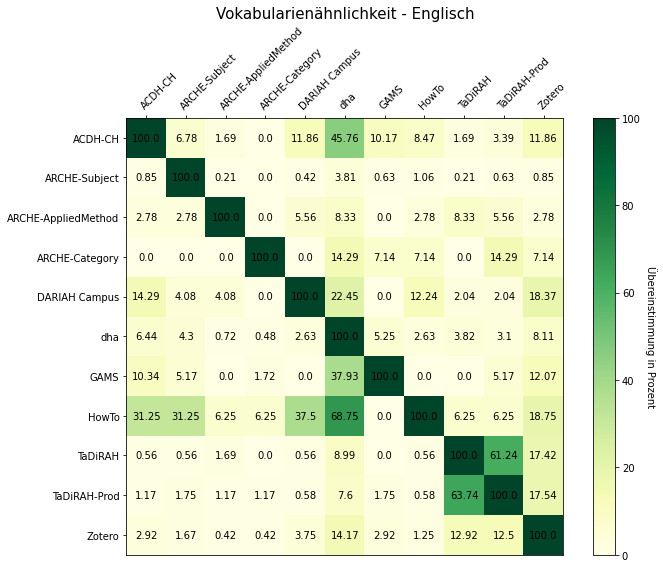

In [165]:
#Heatmap - Englisch

heatmap(headers_en, tabelle_proz_en, "Vokabularienähnlichkeit - Englisch")

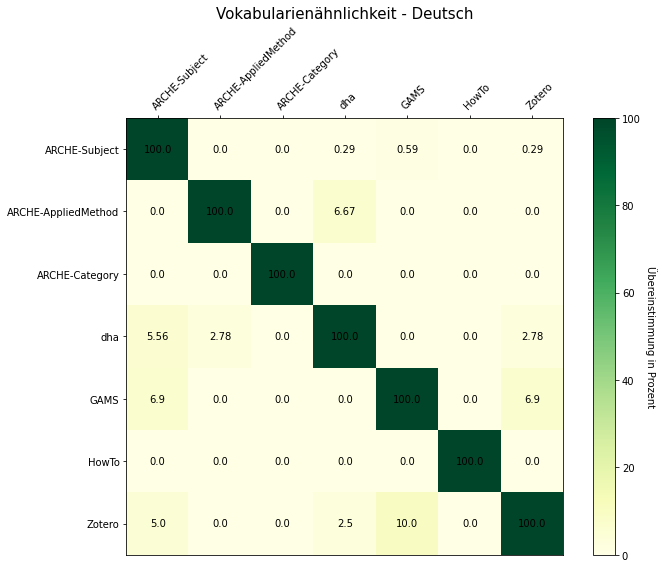

In [166]:
heatmap(headers_de, tabelle_proz_de, "Vokabularienähnlichkeit - Deutsch")

In [162]:
#Längenvergleich der unterschiedlichen Vokabularien

print("ACDH-CH-Website:", len(acdh))
print("ARCHE_ - EN:", len(arche_hasSubject_en) + len(arche_hasAppliedMethod_en) + len(arche_hasCategory_en))
print("-- hasSubject:", len(arche_hasSubject_en))
print("-- hasAppliedMethod:", len(arche_hasAppliedMethod_en))
print("-- hasCategory:", len(arche_hasCategory_en))
print("ARCHE_ - DE:", len(arche_hasSubject_de) + len(arche_hasAppliedMethod_de) + len(arche_hasCategory_de))
print("-- hasSubject:", len(arche_hasSubject_de))
print("-- hasAppliedMethod:", len(arche_hasAppliedMethod_de))
print("-- hasCategory:", len(arche_hasCategory_de))
print("DARIAH Campus:", len(dc))
print("ACDH-CH HowTo - EN:", len(ht_en))
print("ACDH-CH HowTo - DE:", len(ht_de))
print("dha - EN:", len(dha_en))
print("dha - DE:", len(dha_de))
print("GAMS - EN:", len(gams_en))
print("GAMS - DE:", len(gams_de))
print("TaDiRAH:", len(tadirah))
print("TaDiRAH-Products:", len(tadirah_prod))
print("Zotero (Konde-Weißbuch) - EN:", len(zotero_en))
print("Zotero (Konde-Weißbuch) - DE:", len(zotero_de))
print()
print("Tags Englisch gesamt:", len(tags_en))
print("Tags Deutsch gesamt:", len(tags_de))

ACDH-CH-Website: 59
ARCHE_ - EN: 523
-- hasSubject: 473
-- hasAppliedMethod: 36
-- hasCategory: 14
ARCHE_ - DE: 707
-- hasSubject: 678
-- hasAppliedMethod: 15
-- hasCategory: 14
DARIAH Campus: 49
ACDH-CH HowTo - EN: 16
ACDH-CH HowTo - DE: 1
dha - EN: 419
dha - DE: 36
GAMS - EN: 58
GAMS - DE: 58
TaDiRAH: 178
TaDiRAH-Products: 171
Zotero (Konde-Weißbuch) - EN: 240
Zotero (Konde-Weißbuch) - DE: 40

Tags Englisch gesamt: 1399
Tags Deutsch gesamt: 829
